# STROKE PREDICTION USING (XGBOOST, LIGHTGBM, CATBOOST)

## 1.0 DATA PREPROCCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import modules for Handling missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer,
                            IterativeImputer,
                            KNNImputer)

#Encoding
from sklearn.preprocessing import (StandardScaler,
                                   RobustScaler,
                                  LabelEncoder,
                                  OneHotEncoder)
from sklearn.compose import ColumnTransformer

#model Selection
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold,
                                     KFold,
                                     RepeatedKFold,
                                     cross_val_score,
                                     cross_validate
                                    )
#data balancing library
from imblearn.over_sampling import (SMOTE,
                                    ADASYN,
                                   RandomOverSampler)
from imblearn.combine import (SMOTETomek,SMOTEENN)

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             AdaBoostClassifier,
                             GradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#metrics
from sklearn import metrics
from sklearn.metrics import (accuracy_score,
                             auc,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix,
                             classification_report,
                             plot_confusion_matrix
                            )
#shap
import shap

In [3]:
#load dataset
df = pd.read_csv('../dataset/stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:>

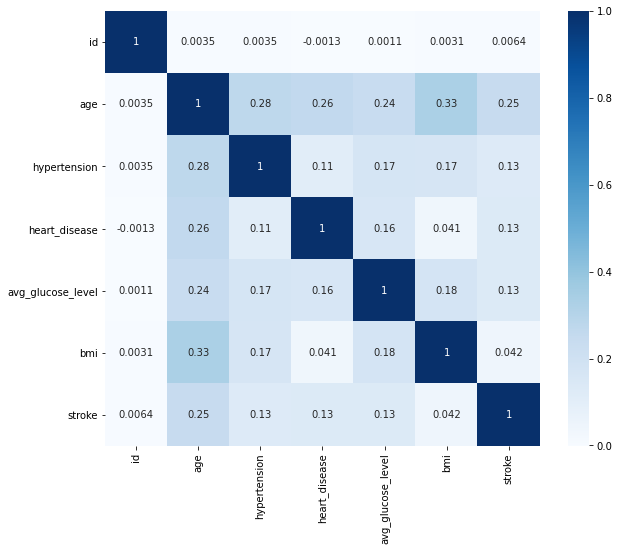

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(method='pearson'),cmap='Blues', annot=True, square=True)

In [5]:
#check for missing value
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### 1.1 Handling Missing Value in BMI column Using KNNIMPUTER Method

In [6]:
#knn imputer
KNN_imp = KNNImputer(n_neighbors=5)
df['bmi'] = KNN_imp.fit_transform(df[['bmi']])

In [7]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### 1.2 Feature Engineering 
#### i. Discretization of Age, BMI, and Avg_glucose_level Features

In [8]:
#treat 'unknown' as null and used mode imputation
df['smoking_status'].replace(to_replace='Unknown',value=df['smoking_status'].mode()[0],inplace=True)

In [9]:
df['age_cat'] = pd.cut(df['age'], bins = [0,12,17, 40,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 18.4, 24.9,30,100], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['avg_glucose_level_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,50,70,180,250,600], labels = ['Very Low','Low', 'Normal', 'High','Very High'])

In [10]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_cat,bmi_cat,avg_glucose_level_cat
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Elderly,Obesity,High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Elderly,Overweight,High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Elderly,Obesity,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Mid Adults,Obesity,Normal
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Elderly,Ideal,Normal


#### ii. Handling Outliers in BMI and Avg_glucose_level

In [11]:
### Thanks for the function https://www.kaggle.com/ankitak46

def remove_outliers(data):
    arr=[]
    #print(max(list(data)))
    q1=np.percentile(data,25)
    q3=np.percentile(data,75)
    iqr=q3-q1
    mi=q1-(1.5*iqr)
    ma=q3+(1.5*iqr)
    #print(mi,ma)
    for i in list(data):
        if i<mi:
            i=mi
            arr.append(i)
        elif i>ma:
            i=ma
            arr.append(i)
        else:
            arr.append(i)
    #print(max(arr))
    return arr

In [12]:
df['bmi'] = remove_outliers(df['bmi'])
df['avg_glucose_level'] = remove_outliers(df['avg_glucose_level'])

#### iii. Encodings (Label and One Hot Encoding)

In [13]:
le = LabelEncoder()
df = pd.get_dummies(df, columns=['work_type','smoking_status'])
df = df.apply(le.fit_transform)
df.drop('id',axis=1, inplace=True)

In [14]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,age_cat,bmi_cat,avg_glucose_level_cat,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,88,0,1,1,1,3374,240,1,2,1,0,0,0,1,0,0,1,0,0
1,0,82,0,0,1,0,3374,162,1,2,2,0,0,0,0,1,0,0,1,0
2,1,101,0,1,1,0,2483,199,1,2,1,2,0,0,1,0,0,0,1,0
3,0,70,0,0,1,1,3374,218,1,3,1,2,0,0,1,0,0,0,0,1
4,0,100,1,0,1,0,3374,113,1,2,0,2,0,0,0,1,0,0,1,0


In [15]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'age_cat',
       'bmi_cat', 'avg_glucose_level_cat', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

#### iv. Splitting the Data 

In [16]:
y = df['stroke']
X = df.drop('stroke', axis=1)

print('X Shape', X.shape)
print('Y Shape',y.shape)

X Shape (5110, 19)
Y Shape (5110,)


### 1.3 Balancing Technique

In [17]:
#SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_re, y_train_re = smote_enn.fit_resample(X,y)

In [18]:
#SMOTE+TOMEK LINK
#smote_tomek=SMOTETomek(random_state=42)
#X_train_re, y_train_re = smote_tomek.fit_resample(X,y)

In [19]:
#Smote
#sm = SMOTE()
#X_train_re, y_train_re = sm.fit_resample(X,y)

In [20]:
#Over Sampling
#ros = RandomOverSampler(random_state=42)
#X_train_re, y_train_re = ros.fit_resample(X,y)

In [21]:
#ADASYN
#adasyn = ADASYN(random_state=42)
#X_train_re, y_train_re = adasyn.fit_resample(X,y)

Text(0.5, 1.0, 'Class Distribution Before Sampling')

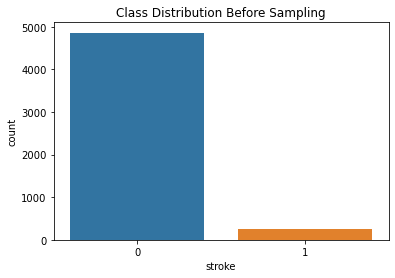

In [22]:
sns.countplot(data = df, x = y)
plt.title('Class Distribution Before Sampling')
#plt.savefig('../images/b_sample.png')

Text(0.5, 1.0, 'Class Distribution After Sampling')

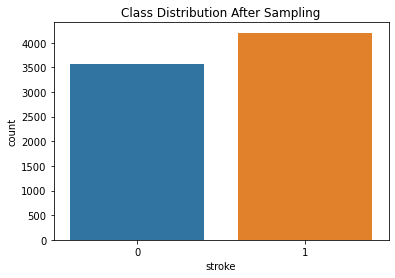

In [23]:
sns.countplot(data = df, x = y_train_re)
plt.title('Class Distribution After Sampling')
#plt.savefig('../images/f_sample.png')

In [24]:
#split
X_train, X_test, y_train, y_test = train_test_split(X_train_re,y_train_re,test_size=0.2, random_state=42)

In [25]:
X_train.shape

(6223, 19)

In [26]:
X_test.shape

(1556, 19)

In [27]:
#Scaling
rc = RobustScaler()
sc = StandardScaler()

#Robust Scaler
#X_train = rc.fit_transform(X_train)
#X_test = rc.transform(X_test)

#Standard Scaler
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 2.0 MODELS

In [28]:
#model building
def model_score(model, X_train=X_train, X_test=X_test, y_train=y_train,cv=10):
    #scoring = {'acc': 'accuracy',
            #'f1': 'f1'}
    #scores = cross_validate(model, X = X_train,y = y_train, cv=cv, scoring=scoring,n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    #print performance
    print(f'Training Accuracy: {round(accuracy_score(y_train,model.predict(X_train))*100,3)}')
    print(f'Test Accuracy: {round(accuracy_score(y_test,y_pred)*100,3)}')
    print(f'f1 Score: {round(f1_score(y_test,y_pred),3)}')
    print(f'Precision Score: {round(precision_score(y_test,y_pred),3)}')
    print(f'Recall Score: {round(recall_score(y_test,y_pred),3)}')
    print(f'AUC Score: {roc_auc_score(y_test,y_pred)}')
    
    #print(f"K-Fold Validation Mean Accuracy Score: {round(np.mean(scores['test_acc']),3)}")
    #print(f"K-Fold Validation Mean f1 Score: {round(np.mean(scores['test_f1']),3)}")
    print(classification_report(y_test,y_pred))
        
    #plot confusion matrix
    plt.figure(figsize = (6, 4))
    #sns.heatmap(confusion_matrix(y_test,y_pred), cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
     #       yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
    #plt.yticks(rotation = 0)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, display_labels=['No Stroke','Stroke']) 
    plt.savefig('../images/cm_cat1.png')
   

In [29]:
#roc curve
def plot_roc_curve(model,X_test=X_test, y_test=y_test):
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    sns.set_theme(style = 'white')
    plt.figure(figsize = (8, 8))
    plt.plot(fpr, tpr, marker='.', color='green', label = 'AUC = %0.3f' % roc_auc)
    #plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
    plt.axis('tight')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    #plt.show()
    #saving the image to disk
    #fig = s.get_figure()
    #fig.savefig('../images/stroke_dist.png')
    plt.savefig('../images/auc_roc_cat.png')

### 2.1 XGBOOST Classifier (Default Hyparameters)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:52:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 100.0
Test Accuracy: 98.265
f1 Score: 0.984
Precision Score: 0.984
Recall Score: 0.983
AUC Score: 0.9826193473692242
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       729
           1       0.98      0.98      0.98       827

    accuracy                           0.98      1556
   macro avg       0.98      0.98      0.98      1556
weighted avg       0.98      0.98      0.98      1556



<Figure size 432x288 with 0 Axes>

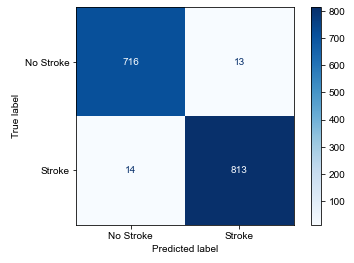

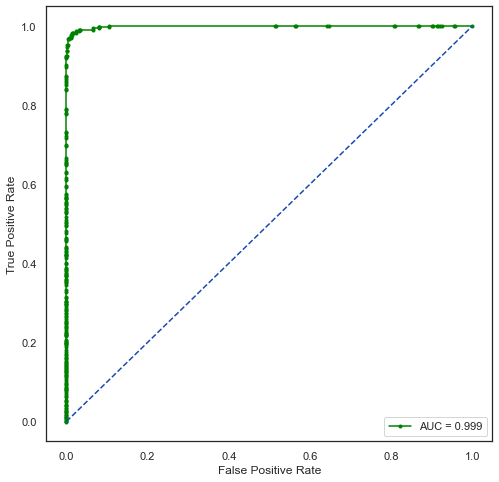

In [30]:
xgb = XGBClassifier()
model_score(xgb)
plot_roc_curve(xgb)

In [37]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


In [51]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[1])

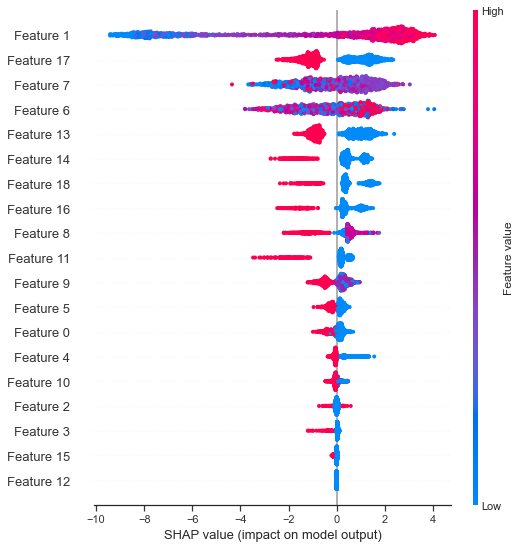

In [54]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

In [46]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
sns.set_style('white')
shap.summary_plot(shap_values[1], X_test, alpha=0.5)

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [47]:
explainer = shap.Explainer(xgb.predict_proba, data.loc[:, columns])
explainer_output = explainer(data.loc[:, columns])

expected_values = explainer_output.base_values[:1, :].reshape(-1)
shap_values = explainer_output.values

NameError: name 'data' is not defined

In [33]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_values[1], shap.values[1],X_test[1])

AttributeError: 'Tree' object has no attribute 'expected_values'

<AxesSubplot:>

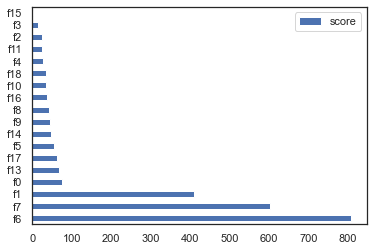

In [31]:
feature_importance = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)
data.plot(kind='barh')

In [32]:
pd.DataFrame(xgb.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)

AttributeError: 'XGBClassifier' object has no attribute 'get_fscore'

In [ ]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=6)

### 2.2 LGBM Classifier (Default Hyparameters)

Training Accuracy: 99.807
Test Accuracy: 98.008
f1 Score: 0.981
Precision Score: 0.978
Recall Score: 0.984
AUC Score: 0.9797945870094198
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       729
           1       0.98      0.98      0.98       827

    accuracy                           0.98      1556
   macro avg       0.98      0.98      0.98      1556
weighted avg       0.98      0.98      0.98      1556



<Figure size 432x288 with 0 Axes>

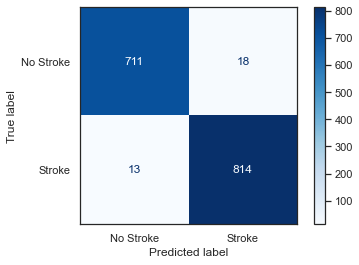

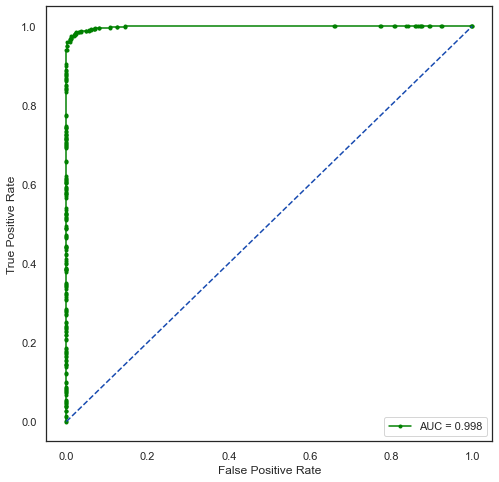

In [38]:
lgbm = LGBMClassifier()
model_score(lgbm)
plot_roc_curve(lgbm)

### 2.3 AdaBOOST Classifier (Default Hyparameters)

Training Accuracy: 94.392
Test Accuracy: 93.959
f1 Score: 0.944
Precision Score: 0.936
Recall Score: 0.952
AUC Score: 0.9387791661068566
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       729
           1       0.94      0.95      0.94       827

    accuracy                           0.94      1556
   macro avg       0.94      0.94      0.94      1556
weighted avg       0.94      0.94      0.94      1556



<Figure size 432x288 with 0 Axes>

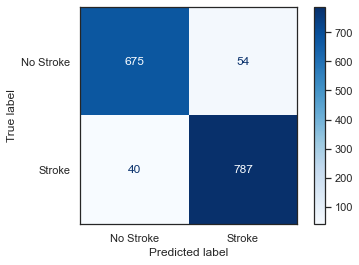

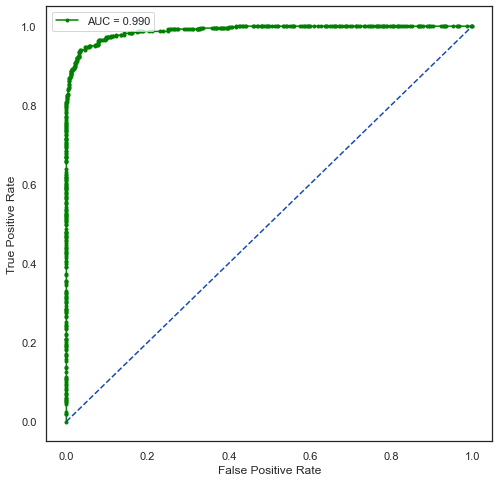

In [42]:
ada = AdaBoostClassifier()
model_score(ada)
plot_roc_curve(ada)

### 2.3 CATBOOST Classifier (Default Hyparameters)

Learning rate set to 0.022489
0:	learn: 0.6682254	total: 6.61ms	remaining: 6.6s
1:	learn: 0.6437278	total: 13.1ms	remaining: 6.56s
2:	learn: 0.6189572	total: 19.4ms	remaining: 6.43s
3:	learn: 0.5988668	total: 25.8ms	remaining: 6.43s
4:	learn: 0.5762054	total: 32.3ms	remaining: 6.42s
5:	learn: 0.5445009	total: 39.2ms	remaining: 6.49s
6:	learn: 0.5296406	total: 45.4ms	remaining: 6.44s
7:	learn: 0.5126262	total: 51.7ms	remaining: 6.41s
8:	learn: 0.4983419	total: 59.4ms	remaining: 6.54s
9:	learn: 0.4848804	total: 65.6ms	remaining: 6.5s
10:	learn: 0.4605889	total: 72.2ms	remaining: 6.49s
11:	learn: 0.4475442	total: 78.5ms	remaining: 6.46s
12:	learn: 0.4366755	total: 85.1ms	remaining: 6.46s
13:	learn: 0.4250635	total: 91.4ms	remaining: 6.44s
14:	learn: 0.4139378	total: 97.6ms	remaining: 6.41s
15:	learn: 0.3970547	total: 104ms	remaining: 6.39s
16:	learn: 0.3879327	total: 110ms	remaining: 6.36s
17:	learn: 0.3775848	total: 116ms	remaining: 6.35s
18:	learn: 0.3693713	total: 122ms	remaining: 6.32

173:	learn: 0.1109631	total: 1.26s	remaining: 5.97s
174:	learn: 0.1107175	total: 1.26s	remaining: 5.96s
175:	learn: 0.1103328	total: 1.27s	remaining: 5.95s
176:	learn: 0.1100273	total: 1.28s	remaining: 5.95s
177:	learn: 0.1098534	total: 1.29s	remaining: 5.94s
178:	learn: 0.1097740	total: 1.29s	remaining: 5.93s
179:	learn: 0.1092732	total: 1.3s	remaining: 5.92s
180:	learn: 0.1088570	total: 1.3s	remaining: 5.91s
181:	learn: 0.1080698	total: 1.31s	remaining: 5.9s
182:	learn: 0.1077792	total: 1.32s	remaining: 5.89s
183:	learn: 0.1074908	total: 1.32s	remaining: 5.88s
184:	learn: 0.1073724	total: 1.33s	remaining: 5.86s
185:	learn: 0.1071593	total: 1.34s	remaining: 5.85s
186:	learn: 0.1069708	total: 1.34s	remaining: 5.84s
187:	learn: 0.1067970	total: 1.35s	remaining: 5.83s
188:	learn: 0.1065679	total: 1.36s	remaining: 5.82s
189:	learn: 0.1063071	total: 1.36s	remaining: 5.81s
190:	learn: 0.1060114	total: 1.37s	remaining: 5.8s
191:	learn: 0.1057909	total: 1.37s	remaining: 5.78s
192:	learn: 0.10

355:	learn: 0.0761119	total: 2.5s	remaining: 4.52s
356:	learn: 0.0759861	total: 2.51s	remaining: 4.51s
357:	learn: 0.0758852	total: 2.51s	remaining: 4.51s
358:	learn: 0.0757839	total: 2.52s	remaining: 4.5s
359:	learn: 0.0756866	total: 2.53s	remaining: 4.49s
360:	learn: 0.0756030	total: 2.53s	remaining: 4.49s
361:	learn: 0.0755024	total: 2.54s	remaining: 4.48s
362:	learn: 0.0753922	total: 2.55s	remaining: 4.47s
363:	learn: 0.0752785	total: 2.55s	remaining: 4.46s
364:	learn: 0.0751282	total: 2.56s	remaining: 4.45s
365:	learn: 0.0750469	total: 2.56s	remaining: 4.44s
366:	learn: 0.0749097	total: 2.57s	remaining: 4.43s
367:	learn: 0.0748365	total: 2.58s	remaining: 4.43s
368:	learn: 0.0747722	total: 2.58s	remaining: 4.42s
369:	learn: 0.0746631	total: 2.59s	remaining: 4.41s
370:	learn: 0.0745120	total: 2.6s	remaining: 4.4s
371:	learn: 0.0743671	total: 2.6s	remaining: 4.39s
372:	learn: 0.0742083	total: 2.61s	remaining: 4.39s
373:	learn: 0.0740564	total: 2.62s	remaining: 4.38s
374:	learn: 0.073

531:	learn: 0.0564405	total: 3.72s	remaining: 3.27s
532:	learn: 0.0563480	total: 3.73s	remaining: 3.26s
533:	learn: 0.0562427	total: 3.73s	remaining: 3.26s
534:	learn: 0.0561726	total: 3.74s	remaining: 3.25s
535:	learn: 0.0561229	total: 3.75s	remaining: 3.24s
536:	learn: 0.0560227	total: 3.75s	remaining: 3.24s
537:	learn: 0.0558583	total: 3.76s	remaining: 3.23s
538:	learn: 0.0557551	total: 3.77s	remaining: 3.22s
539:	learn: 0.0556356	total: 3.77s	remaining: 3.21s
540:	learn: 0.0555597	total: 3.78s	remaining: 3.21s
541:	learn: 0.0554563	total: 3.79s	remaining: 3.2s
542:	learn: 0.0553549	total: 3.79s	remaining: 3.19s
543:	learn: 0.0552313	total: 3.8s	remaining: 3.18s
544:	learn: 0.0551553	total: 3.81s	remaining: 3.18s
545:	learn: 0.0550207	total: 3.81s	remaining: 3.17s
546:	learn: 0.0549091	total: 3.82s	remaining: 3.16s
547:	learn: 0.0548359	total: 3.83s	remaining: 3.15s
548:	learn: 0.0547617	total: 3.83s	remaining: 3.15s
549:	learn: 0.0547045	total: 3.84s	remaining: 3.14s
550:	learn: 0.

697:	learn: 0.0443834	total: 4.95s	remaining: 2.14s
698:	learn: 0.0442298	total: 4.96s	remaining: 2.13s
699:	learn: 0.0441599	total: 4.97s	remaining: 2.13s
700:	learn: 0.0440553	total: 4.97s	remaining: 2.12s
701:	learn: 0.0440139	total: 4.98s	remaining: 2.12s
702:	learn: 0.0439718	total: 4.99s	remaining: 2.11s
703:	learn: 0.0439434	total: 5s	remaining: 2.1s
704:	learn: 0.0438823	total: 5s	remaining: 2.09s
705:	learn: 0.0438338	total: 5.01s	remaining: 2.08s
706:	learn: 0.0438072	total: 5.01s	remaining: 2.08s
707:	learn: 0.0437770	total: 5.02s	remaining: 2.07s
708:	learn: 0.0437036	total: 5.03s	remaining: 2.06s
709:	learn: 0.0436645	total: 5.03s	remaining: 2.06s
710:	learn: 0.0436394	total: 5.04s	remaining: 2.05s
711:	learn: 0.0436046	total: 5.05s	remaining: 2.04s
712:	learn: 0.0435258	total: 5.05s	remaining: 2.03s
713:	learn: 0.0435024	total: 5.06s	remaining: 2.03s
714:	learn: 0.0434091	total: 5.07s	remaining: 2.02s
715:	learn: 0.0433572	total: 5.07s	remaining: 2.01s
716:	learn: 0.04330

866:	learn: 0.0360154	total: 6.2s	remaining: 951ms
867:	learn: 0.0359701	total: 6.2s	remaining: 943ms
868:	learn: 0.0359405	total: 6.21s	remaining: 936ms
869:	learn: 0.0359055	total: 6.22s	remaining: 930ms
870:	learn: 0.0358617	total: 6.23s	remaining: 922ms
871:	learn: 0.0358110	total: 6.23s	remaining: 915ms
872:	learn: 0.0357541	total: 6.24s	remaining: 908ms
873:	learn: 0.0357365	total: 6.25s	remaining: 901ms
874:	learn: 0.0357086	total: 6.25s	remaining: 893ms
875:	learn: 0.0356602	total: 6.26s	remaining: 886ms
876:	learn: 0.0356336	total: 6.26s	remaining: 879ms
877:	learn: 0.0355715	total: 6.27s	remaining: 871ms
878:	learn: 0.0355419	total: 6.28s	remaining: 864ms
879:	learn: 0.0354773	total: 6.29s	remaining: 857ms
880:	learn: 0.0354123	total: 6.29s	remaining: 850ms
881:	learn: 0.0353780	total: 6.3s	remaining: 843ms
882:	learn: 0.0353421	total: 6.3s	remaining: 835ms
883:	learn: 0.0353205	total: 6.31s	remaining: 828ms
884:	learn: 0.0353010	total: 6.32s	remaining: 821ms
885:	learn: 0.03

<Figure size 432x288 with 0 Axes>

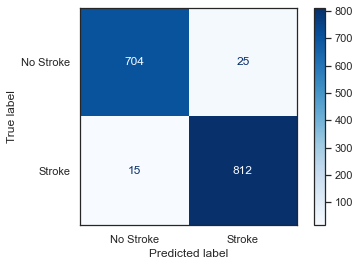

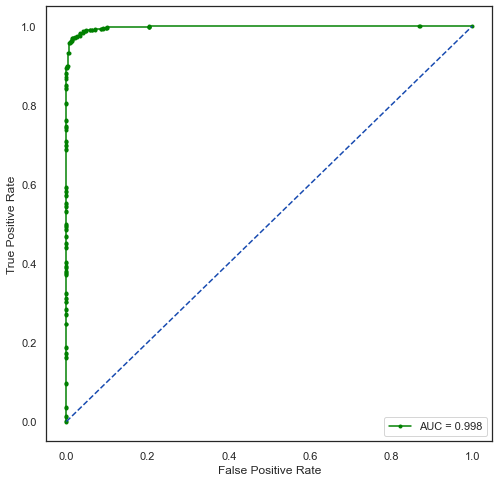

In [45]:
cat = CatBoostClassifier()
model_score(cat)
plot_roc_curve(cat)

In [ ]:
# plot performance matrix
models = []
models.append(['XGBOOST', xgb])
models.append(['LIGHTGBM', lgbm])
models.append(['CATBOOST', cat])
models.append(['ADABOOST', ada])
lst_1 = []
for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    lst_2.append(models[m][0])
    lst_2.append(accuracy_score(y_test,y_pred))
    lst_2.append(roc)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_1.append(lst_2)

per_df = pd.DataFrame(lst_1,columns=['Models','Accuracy','ROC_AUC','Precision','Recall','F1 Score']).sort_values(by='Accuracy', ascending=False)    

In [ ]:
per_df

In [ ]:
fig, ax = plt.subplots()


X = np.arange(4)
rec1 = ax.bar(X + 0.00, per_df['Accuracy'], color = 'b', width = 0.25)
rec2 = ax.bar(X + 0.25, per_df['Precision'], color = 'g', width = 0.25)
rec3 = ax.bar(X + 0.50, per_df['Recall'], color = 'r', width = 0.25)

plt.xlabel("Models")
plt.title("Performance metrics evaluation score")

labels = ['XGBOOST', 'LIGTGBM', 'CATBOOST','ADABOOST']
x = np.arange(len(labels))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend( (bar1, bar2, bar3), ('Accuracy', 'Precision', 'Recall') )
plt.savefig('../images/performance.png')
#plt.show()
